### Pregunta 5
**¿Un Hashtag es más útil a la hora de entrenar un modelo para predecir un emoji?**

Para poder responder a la pregunta de si es más efectivo predecir un emoji a partir de hashtags o el contenido del tweet, se debe generar un nuevo data frame, el cual contenga solo los tweets que tienen hashtags, ya que el mantener los tweets sin hashtags no aporta información relevante para esta pregunta. 

Ahora bien, debido a que los hashtags se escriben sin espacios entre caracteres, no se puede hacer exactamente el mismo pre-procesamiento que se realizó para los caracteres del tweet. Es por esto, que se debe eliminar todo el contenido de cada hashtag que no aporta información sobre el contenido del tweet, en este caso, solo números y puntuación(.,!,#), donde además se debe procurar dejar todo el contenido del hashtag en minúscula.

Cabe recalcar, que de ser necesario, se realizará un reajuste en el balance de clases mediante subsampling, puesto que en la base de datos hay una mayor presencia de ciertos emojis, lo que puede generar resultados poco concluyentes.

Luego del pre-procesamiento, se deberán crear 2 dataset más, uno que contenga los tweets sin los hashtags y otro con solo los hashtags, ya que con esto podremos aplicar diferentes técnicas de clasificación a cada uno de los 3 data frame y podremos cuantificar la efectividad de los hashtags para predecir un emoji. A partir de esto, se ocupará el método de KNN, puesto que este es usado frecuentemente para búsquedas semánticas (procesamiento de lenguaje natural), asociando k puntos de datos más cercanos del dataset train a el punto de consulta (puede ser con distancia euclidiana), es decir, cuando se entrena el clasificador,  se asociaron k palabras para cada emoji y luego mediremos la distancia de cada palabra del test set con las del train set. 

Posteriormente, para poder comparar los resultados entre clasificadores y escoger el más óptimo, se ocupará adicionalmente el clasificador que tenga los mejores resultados en la pregunta 1, ya que el procedimiento es análogo en ambas preguntas. 

En consecuencia, para poder medir la efectividad de cada clasificador y poder hacer una comparación entre ellos, se utilizaran las métricas F1 score y sensibilidad, puesto que existe un desbalance entre clases (cantidad de cada emoji), haciendo que accuracy no sea la mejor métrica en este caso (de igual forma se espera un porcentaje sobre el 70%).

Finalmente, se escogieron estos dos clasificadores por sobre el resto, ya que trabajan de una manera más óptima en presencia de multiclases, acertando un mayor número de veces correctamente al emoji correspondiente, lo cual fue previamente observado en el procedimiento para la pregunta 1. 

In [4]:
import pandas as pd
import numpy as np
import pickle
from string import punctuation
 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})
import plotly.express as px

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer # tokenizer especial para tweets
tt = TweetTokenizer()

In [6]:
file_names = {
    "df_es_mapping": "../../Data/mapping/df_es_mapping.pickle",
    "df_us_mapping": "../../Data/mapping/df_us_mapping.pickle",
    
    "df_es_test": "../../Data/test/df_es_test.pickle",
    "df_us_test": "../../Data/test/df_us_test.pickle",
    
    "df_es_train": "../../Data/train/df_es_train.pickle",
    "df_us_train": "../../Data/train/df_us_train.pickle",
    
    "df_es_trial": "../../Data/trial/df_es_trial.pickle",
    "df_us_trial": "../../Data/trial/df_us_trial.pickle",
}

In [7]:
df_es_train = pickle.load(open(file_names["df_es_train"], "rb"))
df_es_trial = pickle.load(open(file_names["df_es_trial"], "rb"))
df_es_test = pickle.load(open(file_names["df_es_test"], "rb"))

df_us_train = pickle.load(open(file_names["df_us_train"], "rb"))
df_us_trial = pickle.load(open(file_names["df_us_trial"], "rb"))
df_us_test = pickle.load(open(file_names["df_us_test"], "rb"))

df_es_mapping= pickle.load(open(file_names["df_es_mapping"], "rb"))
df_us_mapping= pickle.load(open(file_names["df_us_mapping"], "rb"))


In [10]:
%%capture
df_es_train.head()

id                                               text label
0  793417168469757952  Es imposible quererte más @ Plaza Del Callao -...     0
1  718539939063926790  Disfrutando de buena comida con buena compañía...     4
2  670562346067193856  Muchísimas Felicidades M!!! Nos vemos pronto! ...    11
3  783680728538214400  Y pensar que a esta persona la conozco de hace...    11
4  711210617043075073  ¡Que buenas son las noches así y que buena com...    17

## Tweets en Español

In [19]:
%%time
%%capture
df_es_train['tokenized_text'] = df_es_train['text'].str.lower().apply(tt.tokenize) 
df_es_train.head()

CPU times: total: 3.17 s
Wall time: 3.62 s


In [20]:

%%capture
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_es = stopwords.words('spanish')
print(stopwords_es[:10])

[nltk_data] Downloading package stopwords to C:\Users\Gianluca
[nltk_data]     Musso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
%%capture
from string import punctuation
stopwords_es_withpunct = set(stopwords_es).union(set(punctuation))
print(list(stopwords_es_withpunct)[:10])

In [23]:
%%capture
df_es_train['tokenized_text'] = df_es_train['tokenized_text'].apply(lambda x: [word for word in x if word not in (stopwords_es_withpunct)])
df_es_train["length tokenized"] = df_es_train['tokenized_text'].apply(len)
df_es_train.head()

In [24]:
from nltk.stem import PorterStemmer

# puede ser porter o wnl
porter = PorterStemmer()
wnl = WordNetLemmatizer()

In [26]:
%%capture
df_es_train['StemmedTokenized_text'] = df_es_train['tokenized_text'].apply(lambda x: [porter.stem(word) for word in x])

In [27]:

%%capture
df_es_train.head()

In [29]:
# Obtener el contenido de los hashtags de cada tweet del df ya filtrado
import re 
df_es_only_hashtags = pd.DataFrame()
df_es_only_hashtags['text']=df_es_train['text'].apply(lambda x: re.findall(r"#(\w+)", x))
df_es_only_hashtags[df_es_only_hashtags['text'].apply(lambda d: len(d)) > 0]


text
11                               [mama]
14     [boy, girls, friends, day, work]
27                          [twinseurs]
31                       [sananton2016]
32                           [Mallorca]
...                                 ...
81300            [aprovechandoelverano]
81307                          [family]
81308        [codigodescuento, SUITATP]
81316                [Baco, madrid2016]
81321    [friends, Madrid, Spain, cena]

[24025 rows x 1 columns]

In [33]:
%%capture
# este es el dataset de train completo filtrado con solo los tweets que tienen hashtag
df_es_train_filtered = df_es_train[df_es_only_hashtags['text'].apply(lambda d: len(d)) > 0]
df_es_train_filtered['hashtags'] = df_es_only_hashtags['text']

df_es_train_filtered.head()


In [35]:
%%capture
# se agrega al train las columnas tokenizadas con y sin hashtags
df_es_train_filtered['StemmedTokenized_text_wo_hashtag'] = df_es_train_filtered['StemmedTokenized_text'].apply(lambda li: [word for word in li if not word.startswith('#')])
df_es_train_filtered

In [39]:
%%capture
df_es_train_filtered['StemmedTokenized_text_as_str'] = df_es_train_filtered['StemmedTokenized_text'].astype(object).apply(lambda x: ' '.join([str(i) for i in x]))
df_es_train_filtered['StemmedTokenized_text_wo_hashtag_as_str'] = df_es_train_filtered['StemmedTokenized_text_wo_hashtag'].astype(object).apply(lambda x: ' '.join([str(i) for i in x]))
df_es_train_filtered['hashtags_as_str'] = df_es_train_filtered['hashtags'].astype(object).apply(lambda x: ' '.join([str(i) for i in x]))

In [40]:
df_es_train_filtered.head()


id                                               text  \
11  732910832930062336  Como me gusta reunirme con mi madre aun que si...   
14  795284818866995200  Descansando un poco en el trabajo #boy #girls ...   
27  694634313728532480  @user ya tenemos nuestro medidor de altura par...   
31  689892121680056321  Los 4 fantásticamente quemados #sananton2016 @...   
32  795575808647696385  Sweet home! #Mallorca (@ Aeropuerto de Palma d...   

   label                                     tokenized_text  length tokenized  \
11     5  [gusta, reunirme, madre, aun, siempre, caen, b...                 9   
14    13  [descansando, trabajo, #boy, #girls, #friends,...                 9   
27     1     [@user, medidor, altura, #twinseurs, algemesí]                 5   
31     2  [4, fantásticamente, quemados, #sananton2016, ...                 9   
32     4  [sweet, home, #mallorca, aeropuerto, palma, ma...                 7   

                                StemmedTokenized_text  \
11  [gusta, reunirm, madr, aun, siempr, caen, bron...   
14  [descansando, trabajo, #boy, #girl, #friend, #...   
27      [@user, medidor, altura, #twinseur, algemesí]   
31  [4, fantásticament, quemado, #sananton2016, pu...   
32  [sweet, home, #mallorca, aeropuerto, palma, ma...   

                            hashtags  \
11                            [mama]   
14  [boy, girls, friends, day, work]   
27                       [twinseurs]   
31                    [sananton2016]   
32                        [Mallorca]   

                     StemmedTokenized_text_wo_hashtag  \
11  [gusta, reunirm, madr, aun, siempr, caen, bron...   
14              [descansando, trabajo, madrid, spain]   
27                 [@user, medidor, altura, algemesí]   
31  [4, fantásticament, quemado, puerto, lápice, c...   
32  [sweet, home, aeropuerto, palma, mallorca, @user]   

                         StemmedTokenized_text_as_str  \
11  gusta reunirm madr aun siempr caen bronca #mama …   
14  descansando trabajo #boy #girl #friend #day #w...   
27            @user medidor altura #twinseur algemesí   
31  4 fantásticament quemado #sananton2016 puerto ...   
32  sweet home #mallorca aeropuerto palma mallorca...   

              StemmedTokenized_text_wo_hashtag_as_str  \
11        gusta reunirm madr aun siempr caen bronca …   
14                   descansando trabajo madrid spain   
27                      @user medidor altura algemesí   
31  4 fantásticament quemado puerto lápice castill...   
32         sweet home aeropuerto palma mallorca @user   

               hashtags_as_str  
11                        mama  
14  boy girls friends day work  
27                   twinseurs  
31                sananton2016  
32                    Mallorca

## KNN without Hashtag

In [42]:
%%capture
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_es_train_filtered['StemmedTokenized_text_wo_hashtag_as_str'])
y = df_es_train_filtered['label']
X

In [46]:
# entrenar knn con hashtags
import pandas
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import CountVectorizer

# comparar metricas como recall precision accuracy f1

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [47]:
%%capture
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))



In [48]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.42
Accuracy of K-NN classifier on test set: 0.18


### A continuación usamos los parámetros encontrados en el GridSearch para español en el hito anterior, siendo alpha = 0.2 y df = 5.

## NB without Hashtags

In [50]:
%%capture
from sklearn.naive_bayes import MultinomialNB
vectorizer = CountVectorizer(min_df=5)

clf = MultinomialNB(alpha=0.2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

In [51]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.42
Accuracy of K-NN classifier on test set: 0.18


## KNN with Hashtag

In [52]:
%%capture
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_es_train_filtered['StemmedTokenized_text_as_str'])
y = df_es_train_filtered['label']
X

In [ ]:
# entrenar knn con hashtags

# comparar metricas como recall precision accuracy f1

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [53]:
%%capture
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.44
Accuracy of K-NN classifier on test set: 0.20


## NB with Hashtags

In [54]:
%%capture
vectorizer = CountVectorizer(min_df=5)

clf = MultinomialNB(alpha=0.2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.44
Accuracy of K-NN classifier on test set: 0.20


## KNN only hashtags

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_es_train_filtered['hashtags_as_str'])
y = df_es_train_filtered['label']
X

<24025x29354 sparse matrix of type '<class 'numpy.int64'>'
	with 65227 stored elements in Compressed Sparse Row format>

In [56]:
# entrenar knn con hashtags


# comparar metricas como recall precision accuracy f1

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [57]:
%%capture
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

In [58]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.43
Accuracy of K-NN classifier on test set: 0.21


## NB only Hashtags

In [59]:
%%capture
vectorizer = CountVectorizer(min_df=5)

clf = MultinomialNB(alpha=0.2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

In [60]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.43
Accuracy of K-NN classifier on test set: 0.21


## Histograma KNN

In [61]:
%matplotlib inline
import pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas
#import seaborn
#seaborn.set(style='ticks')

df_knn=pd.DataFrame()
df_knn['Atribute'] = ['precision', 'recall', 'f1-score', 'accuracy train_set', 'accuracy test_set']
df_knn['KNN_w_hashtags'] = [0.22, 0.08, 0.08, 0.44, 0.20]
df_knn['KNN_only_hashtags'] = [0.18, 0.09, 0.09, 0.43, 0.21]
df_knn['KNN_wo_hashtags'] = [0.12, 0.08, 0.07, 0.42, 0.18]
 
df_knn


Atribute  KNN_w_hashtags  KNN_only_hashtags  KNN_wo_hashtags
0           precision            0.22               0.18             0.12
1              recall            0.08               0.09             0.08
2            f1-score            0.08               0.09             0.07
3  accuracy train_set            0.44               0.43             0.42
4   accuracy test_set            0.20               0.21             0.18

<AxesSubplot:xlabel='Atribute'>

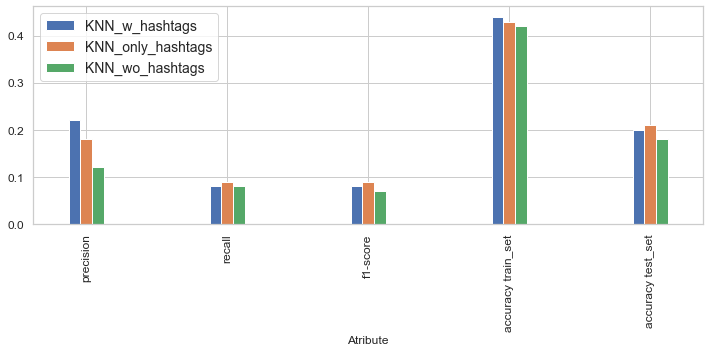

In [62]:

df_knn.plot.bar(x='Atribute',figsize=(12,4), width=0.25)


## Multinomial NB Histograma

In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
#import seaborn
#seaborn.set(style='ticks')

df=pd.DataFrame()
df['Atribute'] = ['precision', 'recall', 'f1-score','accuracy train_set', 'accuracy test_set']
df['Mult_NB_w_hashtags'] = [0.18, 0.16, 0.15, 0.44, 0.20]
df['Mult_NB_only_hashtags'] = [0.24, 0.14, 0.14, 0.43, 0.21]
df['Mult_NB_wo_hashtags'] = [0.15,      0.12,      0.12, 0.42, 0.18]
 
df


Atribute  Mult_NB_w_hashtags  Mult_NB_only_hashtags  \
0           precision                0.18                   0.24   
1              recall                0.16                   0.14   
2            f1-score                0.15                   0.14   
3  accuracy train_set                0.44                   0.43   
4   accuracy test_set                0.20                   0.21   

   Mult_NB_wo_hashtags  
0                 0.15  
1                 0.12  
2                 0.12  
3                 0.42  
4                 0.18

<AxesSubplot:xlabel='Atribute'>

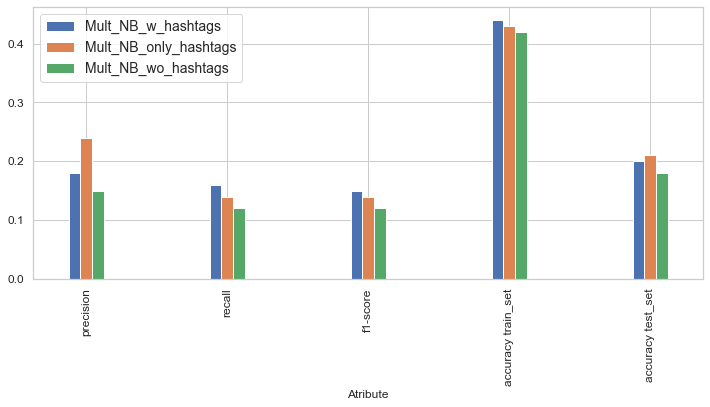

In [64]:

df.plot.bar(x='Atribute',figsize=(12,5), width=0.25)


Al analizar los valores obtenidos de las metricas para cada base de datos (texto con hashtags, solo hashtags y texto sin hashtags) con un clasificador KNN y un Naive-Bayes, podemos observar que a grandes rasgos sí se cumple la hipótesis establecida en un comienzo, y es que los hashtags son más utiles a la hora de predecir un emoji. Los resultados obtenidos varían dependiendo con del clasificador, ya que para KNN obtenemos que la base con mayor f1-score es aquella que incluye solo el contenido de los hashtags, lo que tiene sentido y va acorde con nuestros supuestos, seguido de la base con el texto del tweet y los hashtags y finalmente el contentido de los tweets sin los hashtags. 

Para el clasificador Naive-Bayes, obtenemos un resultado similar, pero para este caso la base que contiene ambos texto del tweet y sus hashtags es quella que presenta un f1-scores más alto, seguido luego por la base que tiene solo los hasthags y finalmente solo el texto de los tweets sin hashtagas.  

Es muyu importante recalcar que para ambos clasificadores, la base de datos que obtuvo el peor resultado a la hora de entrenar el modelo, fue aquella que no incluía los hashtags, siendo en ambos casos peor incluso que aquella que solo contenia los hashtags. En una primera instancia esto podría parecer extraño dado que la base sin hashtags tiene mucho más contenido por tweet lo que nos permitiría pensar que sería mejor para entrenar un modelo, pero ahora bien, los hashtags tienen esa finalidad de ser palabras claves para marcar el contenido que se comparte a través de redes sociales, por lo que si es relativamente lógico que por sí solos permitan tener mejores resultados a la hora de predecir emojis. Finalmente se puede concluir que, al menos para el idioma español, se valida la hipótesis presentada en un inicio. 

## Tweets en Inglés

Para este caso el procedimiento es análogo al anterior, por lo que no se realizarán prints de las bases de datos y solo se mostrarán los resultados finales obtenidos. 

In [65]:
%%capture
%%time
df_us_train['tokenized_text'] = df_us_train['text'].str.lower().apply(tt.tokenize) 
df_us_train.head()

In [66]:
%%capture
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_es = stopwords.words('english')
print(stopwords_es[:10])

[nltk_data] Downloading package stopwords to C:\Users\Gianluca
[nltk_data]     Musso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
%%capture
from string import punctuation
stopwords_us_withpunct = set(stopwords_es).union(set(punctuation))
print(list(stopwords_es_withpunct)[:10])

In [68]:
%%capture
df_us_train['tokenized_text'] = df_us_train['tokenized_text'].apply(lambda x: [word for word in x if word not in (stopwords_es_withpunct)])
df_us_train["length tokenized"] = df_us_train['tokenized_text'].apply(len)
df_us_train.head()

In [69]:
from nltk.stem import PorterStemmer

# puede ser porter o wnl
porter = PorterStemmer()
wnl = WordNetLemmatizer()

In [70]:
%%capture
%%time
df_us_train['StemmedTokenized_text'] = df_us_train['tokenized_text'].apply(lambda x: [porter.stem(word) for word in x])

In [71]:
%%capture
df_us_train.head()

In [72]:
# Obtener el contenido de los hashtags de cada tweet del df ya filtrado
import re 
df_us_only_hashtags = pd.DataFrame()
df_us_only_hashtags['text']=df_us_train['text'].apply(lambda x: re.findall(r"#(\w+)", x))
df_us_only_hashtags[df_us_only_hashtags['text'].apply(lambda d: len(d)) > 0]


text
1                        [hailstate, ily, roomie, 2years]
2       [scored, matcotools, slidehammer, bodymen, ilo...
5                                          [SOULGANG, 65]
9                                           [bigbearbruh]
10                       [LexusUX, ConceptCar, naias2017]
...                                                   ...
387283                 [photographer, olympusomd10markii]
387285                              [runningmanchallenge]
387287  [Seattle, spaceneedle, nictayseatac, vacation,...
387290                        [FamtasyFridsysATL, PullUp]
387291                   [Duluth, Minnesota, Minnesnowta]

[161245 rows x 1 columns]

In [73]:
%%capture
# este es el dataset de train completo filtrado con solo los tweets que tienen hashtag
df_us_train_filtered = df_us_train[df_us_only_hashtags['text'].apply(lambda d: len(d)) > 0]
df_us_train_filtered['hashtags'] = df_us_only_hashtags['text']

df_us_train_filtered


In [74]:
%%capture
# se agrega al train las columnas tokenizadas con y sin hashtags
df_us_train_filtered['StemmedTokenized_text_wo_hashtag'] = df_us_train_filtered['StemmedTokenized_text'].apply(lambda li: [word for word in li if not word.startswith('#')])
df_us_train_filtered

In [75]:
%%capture
df_us_train_filtered['StemmedTokenized_text_as_str'] = df_us_train_filtered['StemmedTokenized_text'].astype(object).apply(lambda x: ' '.join([str(i) for i in x]))
df_us_train_filtered['StemmedTokenized_text_wo_hashtag_as_str'] = df_us_train_filtered['StemmedTokenized_text_wo_hashtag'].astype(object).apply(lambda x: ' '.join([str(i) for i in x]))
df_us_train_filtered['hashtags_as_str'] = df_us_train_filtered['hashtags'].astype(object).apply(lambda x: ' '.join([str(i) for i in x]))

In [76]:
df_us_train_filtered.head()

id                                               text  \
1   663834134037442560  Ready to be a bulldog with rasso #hailstate #i...   
2   747449193350963200  #scored my new #matcotools #slidehammer weight...   
5   739763386783813632   She's Not For You.. | #SOULGANG Custom T #65 /…    
9   677789847302610944  All american at all times // @user // @user ge...   
10  818547203832680450  Tread love. The #LexusUX #ConceptCar @user #na...   

   label                                     tokenized_text  length tokenized  \
1     14  [ready, to, be, bulldog, with, rasso, #hailsta...                14   
2     16  [#scored, my, new, #matcotools, #slidehammer, ...                14   
5     10  [she's, not, for, you, .., #soulgang, custom, ...                10   
9     11  [all, american, at, all, times, @user, @user, ...                14   
10    10  [tread, love, the, #lexusux, #conceptcar, @use...                10   

                                StemmedTokenized_text  \
1   [readi, to, be, bulldog, with, rasso, #hailsta...   
2   [#score, my, new, #matcotool, #slidehamm, weig...   
5   [she', not, for, you, .., #soulgang, custom, t...   
9   [all, american, at, all, time, @user, @user, g...   
10  [tread, love, the, #lexusux, #conceptcar, @use...   

                                             hashtags  \
1                    [hailstate, ily, roomie, 2years]   
2   [scored, matcotools, slidehammer, bodymen, ilo...   
5                                      [SOULGANG, 65]   
9                                       [bigbearbruh]   
10                   [LexusUX, ConceptCar, naias2017]   

                     StemmedTokenized_text_wo_hashtag  \
1   [readi, to, be, bulldog, with, rasso, mississi...   
2       [my, new, weight, all, the, swear, by, it, …]   
5             [she', not, for, you, .., custom, t, …]   
9   [all, american, at, all, time, @user, @user, g...   
10   [tread, love, the, @user, cobo, center, detroit]   

                         StemmedTokenized_text_as_str  \
1   readi to be bulldog with rasso #hailstat #ili ...   
2   #score my new #matcotool #slidehamm weight all...   
5        she' not for you .. #soulgang custom t #65 …   
9   all american at all time @user @user getaway #...   
10  tread love the #lexusux #conceptcar @user #nai...   

              StemmedTokenized_text_wo_hashtag_as_str  \
1   readi to be bulldog with rasso mississippi sta...   
2                 my new weight all the swear by it …   
5                      she' not for you .. custom t …   
9   all american at all time @user @user getaway 森...   
10           tread love the @user cobo center detroit   

                                  hashtags_as_str  
1                     hailstate ily roomie 2years  
2   scored matcotools slidehammer bodymen iloveit  
5                                     SOULGANG 65  
9                                     bigbearbruh  
10                   LexusUX ConceptCar naias2017

## KNN without Hashtag

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_us_train_filtered['StemmedTokenized_text_wo_hashtag_as_str'])
y = df_us_train_filtered['label']
X

<161245x58296 sparse matrix of type '<class 'numpy.int64'>'
	with 1222087 stored elements in Compressed Sparse Row format>

In [78]:
# entrenar knn con hashtags

# comparar metricas como recall precision accuracy f1

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [79]:
%%capture
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))



In [80]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.45
Accuracy of K-NN classifier on test set: 0.21


A continuación usamos los parámetros encontrados en el GridSearch para español en el hito anterior, siendo alpha = 0.2 y df = 10.

## NB without Hashtags

In [81]:
%%capture
vectorizer = CountVectorizer(min_df=10)

clf = MultinomialNB(alpha=0.2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.45
Accuracy of K-NN classifier on test set: 0.21


## KNN with Hashtag

In [83]:
%%capture
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_us_train_filtered['StemmedTokenized_text_as_str'])
y = df_us_train_filtered['label']
X

In [84]:
%%capture
# entrenar knn con hashtags

# comparar metricas como recall precision accuracy f1

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the classifier to the data
knn.fit(X_train,y_train)

In [85]:
%%capture
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.49
Accuracy of K-NN classifier on test set: 0.21


## NB with Hashtags

In [86]:
%%capture
%%time
vectorizer = CountVectorizer(min_df=10)

clf = MultinomialNB(alpha=0.2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.49
Accuracy of K-NN classifier on test set: 0.21


## KNN only hastags

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_us_train_filtered['hashtags_as_str'])
y = df_us_train_filtered['label']
X

<161245x154854 sparse matrix of type '<class 'numpy.int64'>'
	with 405799 stored elements in Compressed Sparse Row format>

In [88]:
# entrenar knn con hashtags

# comparar metricas como recall precision accuracy f1

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [89]:
%%capture
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.38
Accuracy of K-NN classifier on test set: 0.25


## NB only Hashtags

In [90]:
%%capture
vectorizer = CountVectorizer(min_df=10)

clf = MultinomialNB(alpha=0.2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.38
Accuracy of K-NN classifier on test set: 0.25


## Histograma KNN English

In [91]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
#import seaborn
#seaborn.set(style='ticks')

df=pd.DataFrame()
df['Atribute'] = ['precision', 'recall', 'f1-score', 'accuracy train_set', 'accuracy test_set']
df['KNN_w_hashtags'] = [0.18, 0.11, 0.11, 0.47, 0.21]
df['KNN_only_hashtags'] = [0.24, 0.13, 0.14, 0.38, 0.25]
df['KNN_wo_hashtags'] = [ 0.17,0.11,0.11, 0.45, 0.21]

 
df


Atribute  KNN_w_hashtags  KNN_only_hashtags  KNN_wo_hashtags
0           precision            0.18               0.24             0.17
1              recall            0.11               0.13             0.11
2            f1-score            0.11               0.14             0.11
3  accuracy train_set            0.47               0.38             0.45
4   accuracy test_set            0.21               0.25             0.21

<AxesSubplot:xlabel='Atribute'>

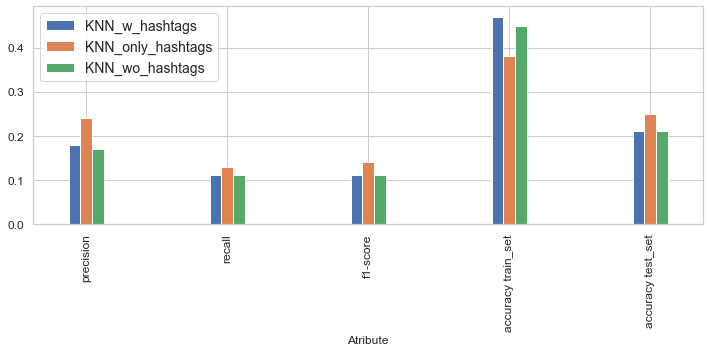

In [ ]:
df.plot.bar(x='Atribute',figsize=(12,4), width=0.25)


## Histograma Multinomial NB English

In [92]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
#import seaborn
#seaborn.set(style='ticks')

df=pd.DataFrame()
df['Atribute'] = ['precision', 'recall', 'f1-score', 'accuracy train_set', 'accuracy test_set']
df['Mult_NB_w_hashtags'] = [0.29,      0.21,      0.22, 0.49, 0.21]
df['Mult_NB_only_hashtags'] = [0.28,      0.18,      0.19, 0.38, 0.25]
df['Mult_NB_wo_hashtags'] = [0.22,      0.18,      0.18, 0.45, 0.21 ]

 
df


Atribute  Mult_NB_w_hashtags  Mult_NB_only_hashtags  \
0           precision                0.29                   0.28   
1              recall                0.21                   0.18   
2            f1-score                0.22                   0.19   
3  accuracy train_set                0.49                   0.38   
4   accuracy test_set                0.21                   0.25   

   Mult_NB_wo_hashtags  
0                 0.22  
1                 0.18  
2                 0.18  
3                 0.45  
4                 0.21

<AxesSubplot:xlabel='Atribute'>

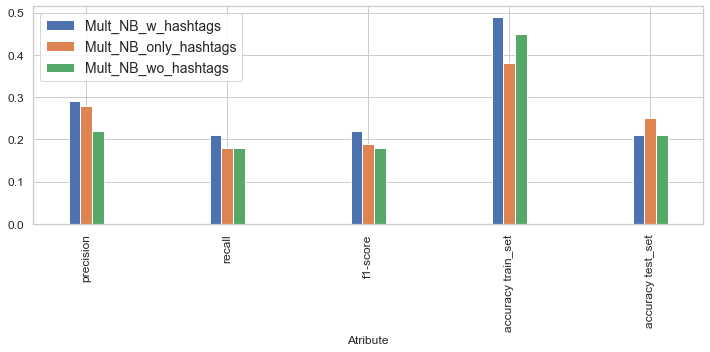

In [93]:
df.plot.bar(x='Atribute',figsize=(12,4), width=0.25)


Podemos ver que para el caso de los tweets en inglés, se da exactamente el mismo comportamiento que para aquellos en español, para ambos clasificadores. Esto nos permite corroborar una vez más que se cumple la hipótesis presentada y establecer que los hashtags permiten predecir de mejor manera un emoji presente en un tweet. 

### Direcciones futuras

Ahora si bien el estudio realizado permitió responder a nuestra pregunta inicial, se podría haber realizado algunos pasos extras para mejorar la calidad del análisis, que no se realizaron prinipalmente por tiempo. Principalmente se podrían estudiar aquellos hashtags que se lograban predecir con una mayor tasa de exitos, tanto para los tweets en español como para los tweets en inglés, para así poder entender en qué caso o qué determina que un hashtag sea "mejor" que otro a la hora de predecir un emoji o una "emoción".